# Two-Fluids SBN with input images vs analytical

In [2]:
%load_ext autoreload
%autoreload 1

In [5]:
import os

import sys
sys.path.append(r'E:\Nonlinear_Optics_LAB\LAB_Repository\Tiago_Code\lab-logbooks\LAB_base_methods_temp')

%aimport slm_controllers
%aimport camera_controllers
%aimport RC_methods


from scipy import *
from numpy import *
from pylab import *
import arrayfire as af
from core_libs.bindings import *
from core_libs.af_loader import *
from core_libs.functions_for_initial_conditions import *
from core_libs.functions_for_fit import *
from core_libs.turbulence_methods import *
from scipy import fftpack
from scipy import special
from matplotlib.pyplot import *
from matplotlib.colors import ListedColormap

from scipy import optimize
import scipy as sp
from IPython.display import Markdown, display
from scipy.special import jv, jn
import enlighten

import h5py

import warnings
warnings.filterwarnings('ignore')

plt.style.use('dark_background')

def printmd(string, color=None):
    colorstr = "#### <span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    

# <font color='blue'>System parameters - configuration</font>

#### <span style='color:green'>$P_{fluid}=$48.8$\mu W$</span>

#### <span style='color:red'>$P_{obs}=$50.2$\mu W$</span>

#### <span style='color:blue'>$c_s=$0.0037</span>

#### <span style='color:blue'>$v=$0.003</span>

#### <span style='color:blue'>$v/c_s=$0.8253</span>

#### <span style='color:blue'>$\xi=$9.78$\mu m$</span>

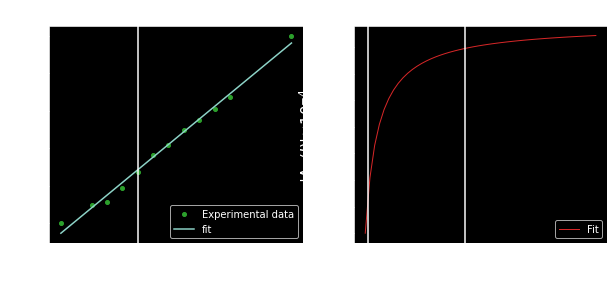

In [8]:
#%matplotlib widget
%matplotlib inline

#########################################################################################################
#Velocity of the fluid
GL = 5000

#Scaling factor of the power meter
power_meter_factor = 1.34+1.6*0

P_green_beam = 48.8 #muW
P_green_beam_corrected = power_meter_factor*P_green_beam
w = 619.5e-4 #cm

#Red beam parameters
P_red_beam = 50.2 #muW
d_bessel = 121.6e-4 #cm

#########################################################################################################

I_fluid = P_green_beam_corrected*1e-3*2/(np.pi*w**2.0)

r_bessel = d_bessel/2.0
I_defect = P_red_beam*1e-3/(np.pi*r_bessel**2.0)

fig = plt.figure(figsize=(10, 4))

rows = 1
columns = 2

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)

plt.subplot(grid[0, 0])

GL_to_load = [0, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 15000]
angle = [0, 0.00244017, 0.00280785, 0.00476556, 0.00679314, 0.0090616, 0.01050736, 0.01238871, 0.013732, 0.01519613, 0.01677856, 0.02503264]


popt_x_ve, pcov_x = sp.optimize.curve_fit(linear_fit, GL_to_load, angle, p0=[0.001, 0.0])

plt.title("$\\theta_{in}=$" + str(np.round(linear_fit(np.array(GL), *popt_x_ve)/(1e-3),3)) + " $mrad$")
plt.plot(GL_to_load, np.array(angle)/(1e-3), linewidth=0, marker="o", markersize=4, color="tab:green", label="Experimental data")
plt.plot(GL_to_load, linear_fit(np.array(GL_to_load), *popt_x_ve)/(1e-3), label="fit")
plt.xlabel("Gray level", fontsize=15)
plt.ylabel("$\\approx\\theta_{in}$ $[mrad]$", fontsize=15)
plt.axvline(x=GL)

plt.legend(loc=0)   

plt.subplot(grid[0, 1])

N_rings_level_2 = [0, 1, 1, 2, 4, 6, 6, 7, 7]
max_or_minimum_level_2 = [1, 0, 1, 1, 0, 0, 1, 1, 1]

delta_phi_level_2 = np.zeros(len(N_rings_level_2))

for i in range(len(delta_phi_level_2)):
    if max_or_minimum_level_2[i]==1:
        delta_phi_level_2[i] = 2.0*N_rings_level_2[i]*np.pi
    else:
        delta_phi_level_2[i] = 2.0*(N_rings_level_2[i]-1)*np.pi
        
k0 = 2.0*np.pi/(532e-9) 
L = 20e-3
delta_n_level_2 = delta_phi_level_2/(k0*L)

power_to_load_level_2 = [0.553, 2.02, 5.86, 12.72, 29.6, 78.1, 192, 512, 961]
intensities_level_2 = 2.0*np.array(power_to_load_level_2)*power_meter_factor*1e-3/(np.pi*(0.0245)**2.0)

delta_n_params, pcov_x = sp.optimize.curve_fit(delta_n_f, intensities_level_2, delta_n_level_2, p0=[1e-4,25])



plt.title("|$\Delta n(I)$|=" + str(np.round(delta_n_f(I_fluid, *delta_n_params)/(1e-4),3)) + "$\\times 10^{-4}$")

I_theo = np.linspace(0, 1000)
plt.plot(I_theo, delta_n_f(I_theo, *delta_n_params)/1e-4, linewidth=1, label='Fit', color="tab:red")
plt.axvline(x=I_fluid)
plt.axvline(x=I_defect)
plt.xlabel("I $mWcm^{-2}$", fontsize=15)
plt.ylabel("|$\Delta n(I)$|$\\times 10^{-4}$", fontsize=15)
plt.legend(loc=0)

plt.tight_layout()

ne = 2.36
k0 = 2.0*np.pi/(532e-9)
cs = np.sqrt(delta_n_f(I_fluid, *delta_n_params)/ne)
fluid_velocity = linear_fit(np.array(GL), *popt_x_ve)/ne
healing_length = 1.0/(ne*k0*cs)

printmd("$P_{fluid}=$" + str(P_green_beam) + "$\mu W$", color="green")
printmd("$P_{obs}=$" + str(P_red_beam) + "$\mu W$", color="red")

printmd("$c_s=$" + str(np.round(cs,4)), color="blue")
printmd("$v=$" + str(np.round(fluid_velocity,4)), color="blue")
printmd("$v/c_s=$" + str(np.round(fluid_velocity/cs,4)), color="blue")

printmd("$\\xi=$" + str(np.round(healing_length/(1e-6),2)) + "$\\mu m$", color="blue")

# <font color='blue'>Measure input fluid and optical obstacle</font>

In [4]:
#Initializate camera
input_camera = 16046
camera = camera_controllers.camera_system('Thorlabs', input_camera)

#Set some camera properties
properties = {'exposure':250, 'image_poll_timeout_ms':10000, 'num_frames':1, 
              'frames_per_trigger_zero_for_unlimited':5, 'binx':2, 'biny':2}

camera.set_properties(properties)

camera.get_camera_ready()


input_fluid = camera.get_image()

#Close camera
camera.close()

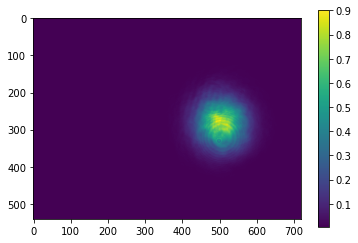

In [5]:
#%matplotlib widget
%matplotlib inline

plt.figure()
plt.imshow(input_fluid)
plt.colorbar()

In [6]:
#Initializate camera
input_camera = 16046
camera = camera_controllers.camera_system('Thorlabs', input_camera)

#Set some camera properties
properties = {'exposure':150, 'image_poll_timeout_ms':10000, 'num_frames':1, 
              'frames_per_trigger_zero_for_unlimited':5, 'binx':2, 'biny':2}

camera.set_properties(properties)

camera.get_camera_ready()


input_axicon = camera.get_image()

#Close camera
camera.close()

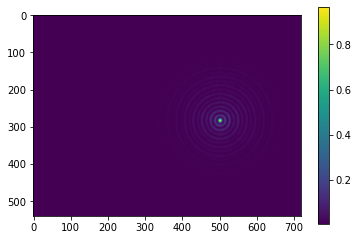

In [8]:
#%matplotlib widget
%matplotlib inline

plt.figure()
plt.imshow(input_axicon)
plt.colorbar()

In [6]:
#matplotlib widget
%matplotlib inline

x_center_axicon = 503
y_center_axicon = 283

y_shape, x_shape = np.shape(input_fluid)

input_fluid_rolled = np.roll(np.roll(input_fluid, int(x_shape/2.0) - x_center_axicon, 1), 
                              int(y_shape/2.0) - y_center_axicon, 0)


input_axicon_rolled = np.roll(np.roll(input_axicon, int(x_shape/2.0) - x_center_axicon, 1),
                              int(y_shape/2.0) - y_center_axicon, 0)

fig = plt.figure(figsize=(16, 4))

rows = 1
columns = 2

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)


plt.subplot(grid[0, 0])
input_fluid_normalized = input_fluid_rolled/np.max(input_fluid_rolled)
plt.imshow(input_fluid_normalized)
plt.colorbar()

plt.subplot(grid[0, 1])
input_axicon_normalized = input_axicon_rolled/np.max(input_axicon_rolled)
plt.imshow(input_axicon_normalized)
plt.colorbar()


input_fluid_normalized_cutted = input_fluid_normalized[:,(int(x_shape/2.0) - int(y_shape/2.0)):(int(x_shape/2.0) + int(y_shape/2.0))]
input_axicon_normalized_cutted = input_axicon_normalized[:,(int(x_shape/2.0) - int(y_shape/2.0)):(int(x_shape/2.0) + int(y_shape/2.0))]

y_shape_cutted, x_shape_cutted = np.shape(input_fluid_normalized_cutted)

input_fluid_normalized_cutted = input_fluid_normalized_cutted[(int(y_shape_cutted/2.0) - 256):(int(y_shape_cutted/2.0) + 256),(int(x_shape_cutted/2.0) - 256):(int(x_shape_cutted/2.0) + 256)]
input_axicon_normalized_cutted = input_axicon_normalized_cutted[(int(y_shape_cutted/2.0) - 256):(int(y_shape_cutted/2.0) + 256),(int(x_shape_cutted/2.0) - 256):(int(x_shape_cutted/2.0) + 256)]

#input_fluid_normalized_cutted = np.transpose(input_fluid_normalized_cutted)
#input_axicon_normalized_cutted = np.transpose(input_axicon_normalized_cutted)

plt.figure()

cmap_fluid = plt.cm.viridis
my_cmap_fluid = cmap_fluid(np.arange(cmap_fluid.N))
my_cmap_fluid[:, -1] = np.linspace(0, 1, cmap_fluid.N)**0.5
my_cmap_fluid = ListedColormap(my_cmap_fluid)

cmap_obstacle = plt.cm.inferno
my_cmap_obstacle = cmap_obstacle(np.arange(cmap_obstacle.N))
my_cmap_obstacle[:, -1] = np.linspace(0, 1, cmap_obstacle.N)**0.5
my_cmap_obstacle = ListedColormap(my_cmap_obstacle)

plt.imshow(input_fluid_normalized_cutted, cmap=my_cmap_fluid)
plt.imshow(input_axicon_normalized_cutted, cmap=my_cmap_obstacle, alpha=0.7)
plt.colorbar()

NameError: name 'input_fluid' is not defined

0.004867693970730528


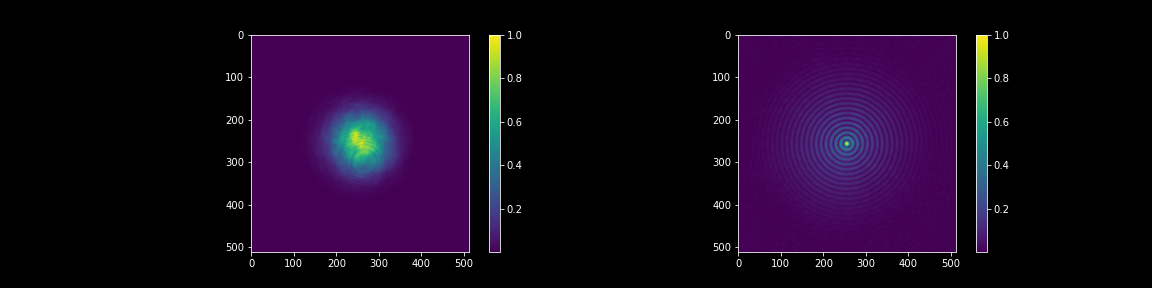

In [72]:
%matplotlib widget

path_to_load = r"E:\Nonlinear_Optics_LAB\LAB_Repository\Tiago_Code\SBN\temp_images"
 
path_temp = path_to_load +  "\\input_axicon_rolled"
h5py_file_to_load = h5py.File(path_temp, 'r')
input_axicon_rolled = h5py_file_to_load["data"][:]
h5py_file_to_load.close()

path_temp = path_to_load +  "\\input_fluid_rolled"
h5py_file_to_load = h5py.File(path_temp, 'r')
input_fluid_rolled = h5py_file_to_load["data"][:]
h5py_file_to_load.close()


input_fluid_normalized = input_fluid_rolled/np.max(input_fluid_rolled)

input_axicon_normalized = input_axicon_rolled/np.max(np.abs(input_axicon_rolled))

y_shape, x_shape = np.shape(input_fluid_normalized)

input_fluid_normalized_cutted = input_fluid_normalized[:,(int(x_shape/2.0) - int(y_shape/2.0)):(int(x_shape/2.0) + int(y_shape/2.0))]
input_axicon_normalized_cutted = input_axicon_normalized[:,(int(x_shape/2.0) - int(y_shape/2.0)):(int(x_shape/2.0) + int(y_shape/2.0))]

y_shape_cutted, x_shape_cutted = np.shape(input_fluid_normalized_cutted)

input_fluid_normalized_cutted = input_fluid_normalized_cutted[(int(y_shape_cutted/2.0) - 256):(int(y_shape_cutted/2.0) + 256),(int(x_shape_cutted/2.0) - 256):(int(x_shape_cutted/2.0) + 256)]
input_axicon_normalized_cutted = input_axicon_normalized_cutted[(int(y_shape_cutted/2.0) - 256):(int(y_shape_cutted/2.0) + 256),(int(x_shape_cutted/2.0) - 256):(int(x_shape_cutted/2.0) + 256)]


fig = plt.figure(figsize=(16, 4))

rows = 1
columns = 2

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)

background_noise_fluid = np.mean(input_fluid_normalized_cutted[:,0])
print(background_noise_fluid)

input_fluid_normalized_cutted = np.abs(input_fluid_normalized_cutted - background_noise_fluid)
input_fluid_normalized_cutted = input_fluid_normalized_cutted/np.max(input_fluid_normalized_cutted)


plt.subplot(grid[0, 0])
plt.imshow(input_fluid_normalized_cutted)
plt.colorbar()

plt.subplot(grid[0, 1])
plt.imshow(np.abs(input_axicon_normalized_cutted))
plt.colorbar()


# <font color='blue'>Calculate simulation parameters</font>

In [73]:
#simulation beam power
If1= I_fluid/I_fluid #mw/cm^-2 fluid beam
If2 = I_defect/I_fluid #mw/cm^-2 defect
Isat = delta_n_params[-1]/I_fluid #mw/cm^-2

#light fluid wavelength
lf=532*10**-9

#k_fluid
kf = (2*pi)/(lf)

#parameters of the crystal
ne = 2.36 #index of refraction n_e
r33 = 235*10**-12 #pm/V
#Biasing electric Field
E0 = 1400*10**2 # V/m

#maximum index variation
#delta_n_max = 0.5*ne**3*r33*E0
delta_n_max = delta_n_params[0]
delta_n = delta_n_f(I_fluid, *delta_n_params)


#absorption
alpha = 100 /(delta_n_max * kf) #1.319 cm^-2
gamma = 1

#healing length
hl = 1/(kf*sqrt(ne*delta_n))

#transverse direction scaling factor
factor_t = kf*sqrt(ne*delta_n)

#propagation direction scaling factor
factor_z = kf*delta_n

##################################################
#Crystal Size
lx=512*3.45*1e-6*2 #2.5*10**-3
ly=512*3.45*1e-6*2 #2.5*10**-3
lz=20*10**-3

#in adimensional units
lx_sim = factor_t*lx
ly_sim = factor_t*ly
lz_sim = factor_z*lz


lx_an=2.5*10**-3
ly_an=2.5*10**-3
lz_an=20*10**-3

#in adimensional units
lx_sim_an = factor_t*lx_an
ly_sim_an = factor_t*ly_an
lz_sim_an = factor_z*lz_an

# <font color='blue'>Create simulation mesh</font>

Define the simulation box parameters

In [74]:
#number of transversal dimensions (only working 1 and 2, necessary for plotting)
dims = 2

#Number of points in x,y transversal dimensions
Nx = 512
Ny = 512

#do not change Nt, Nz
Nt = 1 
Nz = 1

#spatial steps
dx = lx_sim / Nx
dy = ly_sim / Ny
dt = 1.

#spatial steps
dx_an = lx_sim_an / Nx
dy_an = ly_sim_an / Ny
dt = 1.

#integration parameters

stride = 50
dz = 0.005 #.2
total_steps = int(lz_sim/(stride*dz))
print(total_steps)

#define a directory to save
saveDir = r".turbulence_photorefractive_with_images"
saveDir_an = r".turbulence_photorefractive_analytical"

29


# <font color='blue'>Create simulation initial conditions</font>

In [75]:
if Nx != 512 and Ny!=512:
    print("The fields will be interpolated")
    y_shape, x_shape = np.shape(input_fluid_normalized_cutted)
    xx_camera = np.linspace(0, x_shape, x_shape)
    yy_camera = np.linspace(0, y_shape, y_shape)


    fluid_interpolator = interpolate.interp2d(xx_camera, yy_camera, input_fluid_normalized_cutted, kind='cubic')
    defect_interpolator = interpolate.interp2d(xx_camera, yy_camera, input_axicon_normalized_cutted, kind='cubic')

    XX_new = np.linspace(0, x_shape, Nx)
    YY_new = np.linspace(0, y_shape, Ny)

    fluid_rescaled = fluid_interpolator(XX_new, YY_new)
    defect_rescaled = defect_interpolator(XX_new, YY_new)
    
    input_fluid_normalized_cutted_scalled = fluid_rescaled
    input_axicon_normalized_cutted_scalled = defect_rescaled
    
else:
    print("No interpolation")
    input_fluid_normalized_cutted_scalled = input_fluid_normalized_cutted
    input_axicon_normalized_cutted_scalled = input_axicon_normalized_cutted

No interpolation


In [76]:
#Simulation parameters

waist_sim = w*1e-2*factor_t

#dd = 115.3*10**-6*factor_t #bessel
#dd2 = 239*10**-6*factor_t #bessel

dd = d_bessel*1e-2*factor_t/2.0




######Green beam intensity
norm = np.sum(np.abs(np.sqrt(input_fluid_normalized_cutted_scalled))**2.0)*dx*dy/factor_t/factor_t*1e4
I_green_beam = P_green_beam_corrected*1e-3/norm


delta_n = delta_n_f(I_green_beam, *delta_n_params)

#cs = np.sqrt(1/Isat)
theta = fluid_velocity*ne
vx = theta/ne/np.sqrt(ne*delta_n)
gamma = 1

Isat_images = delta_n_params[-1]/I_green_beam #mw/cm^-2

print("vx = " + str(vx))

print("bessel diameter = " + str(dd))

my_simulation = simulation_config(dims, Nx, Ny, Nt, Nz, total_steps, 
                                  stride,dx,dy,dz,dt,0,0, 
                                  alpha, Isat, gamma, saveDir)

#Gaussian field - fluid
my_simulation.initial_condition.add_field(add_field_from_array_with_velocity_normalized(np.sqrt(input_fluid_normalized_cutted_scalled),
                                                                             my_simulation.x_af,
                                                                             my_simulation.y_af, 
                                                                             P_green_beam_corrected*1e-3,
                                                                             I_green_beam,
                                                                             my_simulation.Nx*my_simulation.dx/2, 
                                                                             my_simulation.Ny*my_simulation.dy/2,
                                                                             vx,
                                                                             0,
                                                                             factor_t))

#Noise
my_simulation.initial_condition.add_field(whitenoise_2d_field(my_simulation.x_af, 0.1))


#Axicon - optical defect
my_simulation.initial_condition2.add_field(add_field_from_array_with_velocity_normalized(input_axicon_normalized_cutted_scalled,
                                                                               my_simulation.x_af,
                                                                               my_simulation.y_af, 
                                                                               P_red_beam*1e-3,
                                                                               I_green_beam,
                                                                               my_simulation.Nx*my_simulation.dx/2,
                                                                               my_simulation.Ny*my_simulation.dy/2,
                                                                               0,
                                                                               0,
                                                                               factor_t))




#how many
number_nl_numbers = 0
#(g, power)
nl_numbers = []
my_simulation.number_nl_numbers = number_nl_numbers

#define the nonlinearities of type vector
#how many
number_nl_vectors = 0
nl_vectors=[]
my_simulation.number_nl_vectors = number_nl_vectors







##################################################################################################################

my_simulation_an = simulation_config(dims, Nx, Ny, Nt, Nz, total_steps, 
                                  stride, dx_an, dy_an, dz, dt, 0, 0, 
                                  alpha, Isat, gamma, saveDir_an)

#Gaussian field - fluid
my_simulation_an.initial_condition.add_field(gaussian_2d_field(my_simulation_an.x_af,
                                                               my_simulation_an.y_af,
                                                               np.sqrt(If1),
                                                               waist_sim,
                                                               Nx*dx_an/2,
                                                               Ny*dy_an/2,
                                                               vx,
                                                               0))

#Noise
my_simulation_an.initial_condition.add_field(whitenoise_2d_field(my_simulation_an.x_af, 0.1))

#Axicon - optical defect
my_simulation_an.initial_condition2.add_field(bessel_2d(my_simulation_an.x_af,
                                                        my_simulation_an.y_af, 
                                                        P_red_beam*1e-3,
                                                        I_fluid,
                                                        my_simulation_an.Nx*dx_an/2, 
                                                        my_simulation_an.Ny*dy_an/2, 
                                                        dd,
                                                        factor_t))


##################################################################################################################


#how many
number_nl_numbers = 0
#(g, power)
nl_numbers = []
my_simulation.number_nl_numbers = number_nl_numbers

#define the nonlinearities of type vector
#how many
number_nl_vectors = 0
nl_vectors=[]
my_simulation.number_nl_vectors = number_nl_vectors

vx = 0.3250155470321757
bessel diameter = 6.214546906357573


# <font color='blue'>Test simulation initial conditions</font>

1.7595000000000003
-1.7664


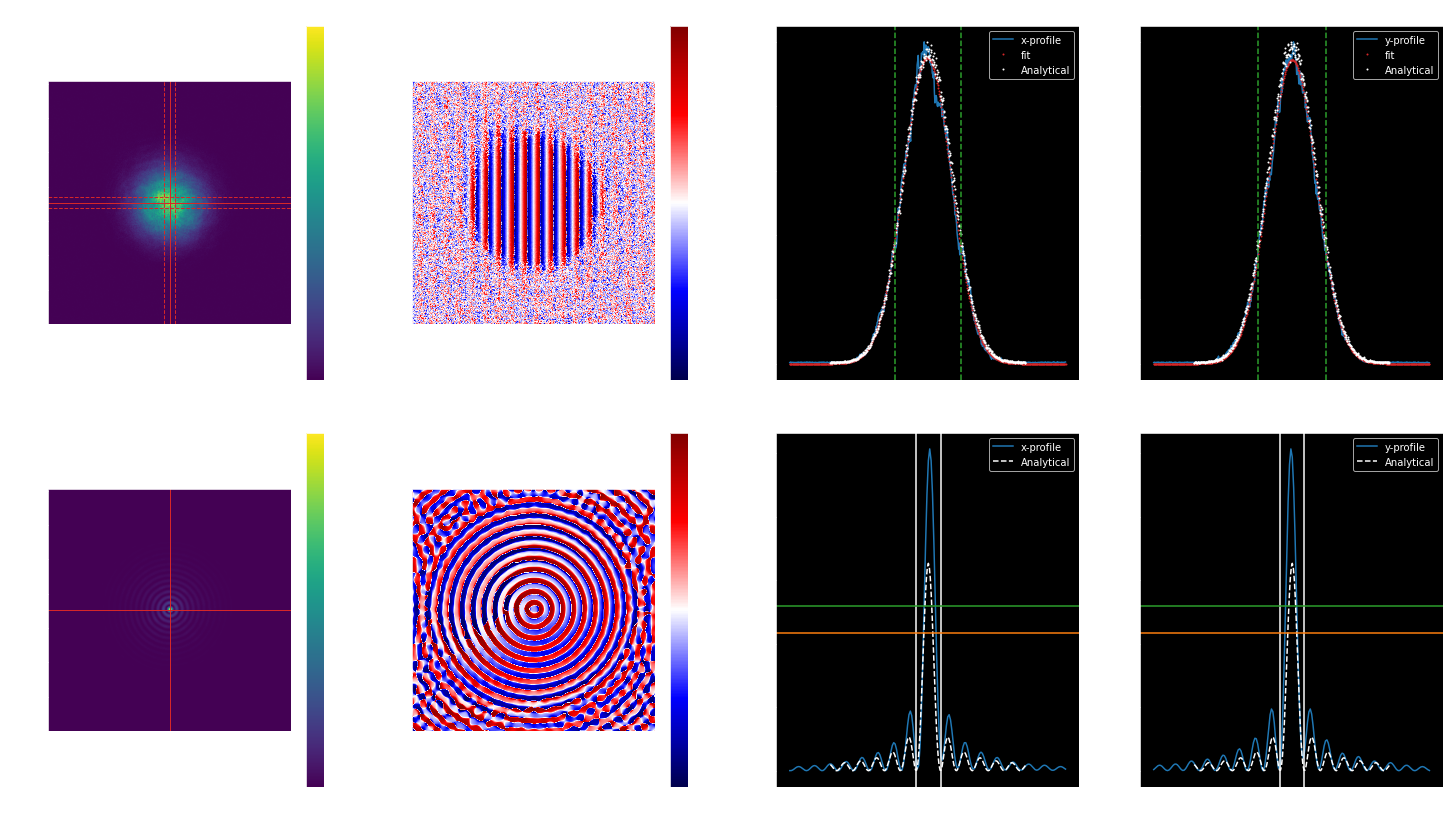

In [77]:
#%matplotlib widget
%matplotlib inline

######################### Gausian

extent_general = [0, Nx*dx/factor_t/(1e-3), 0, Ny*dy/factor_t/(1e-3)]

input_beam_profile = np.transpose(np.abs(my_simulation.initial_condition.np_array)**2.0)
phase_input_beam = np.transpose(np.arctan2(np.imag(my_simulation.initial_condition.np_array), np.real(my_simulation.initial_condition.np_array)))

input_beam_profile_an = np.transpose(np.abs(my_simulation_an.initial_condition.np_array)**2.0)
phase_input_beam_an = np.transpose(np.arctan2(np.imag(my_simulation_an.initial_condition.np_array), np.real(my_simulation_an.initial_condition.np_array)))

y_shape, x_shape = np.shape(input_beam_profile)

dx_units = 1440 / x_shape
dy_units = 1080 / y_shape

x_center_4f = 256
y_center_4f = 256

width_mean = 12

profile_x = input_beam_profile[(y_center_4f-width_mean):(y_center_4f+width_mean), :]
profile_y = input_beam_profile[:, (x_center_4f-width_mean):(x_center_4f+width_mean)]
profile_x = np.mean(profile_x, axis=0)
profile_y = np.mean(profile_y, axis=1)

profile_x_an = input_beam_profile_an[(y_center_4f-width_mean):(y_center_4f+width_mean), :]
profile_y_an = input_beam_profile_an[:, (x_center_4f-width_mean):(x_center_4f+width_mean)]
profile_x_an = np.mean(profile_x_an, axis=0)
profile_y_an = np.mean(profile_y_an, axis=1)



# profile_x = input_beam_profile[y_center, :]
# profile_y = input_beam_profile[:, x_center]


profile_x = profile_x/np.max(profile_x)
profile_y = profile_y/np.max(profile_y)

profile_x_an = profile_x_an/np.max(profile_x_an)
profile_y_an = profile_y_an/np.max(profile_y_an)


x_array = np.array(my_simulation.x_af)[:, y_center_4f] - np.array(my_simulation.x_af)[x_center_4f, y_center_4f]
y_array = np.array(my_simulation.y_af)[x_center_4f, :] - np.array(my_simulation.y_af)[x_center_4f, y_center_4f]

x_array_an = np.array(my_simulation_an.x_af)[:, y_center_4f] - np.array(my_simulation_an.x_af)[x_center_4f, y_center_4f]
y_array_an = np.array(my_simulation_an.y_af)[x_center_4f, :] - np.array(my_simulation_an.y_af)[x_center_4f, y_center_4f]

print(np.max(x_array)/factor_t/(1e-3))
print(np.min(x_array)/factor_t/(1e-3))

popt_x, pcov_x = sp.optimize.curve_fit(gaus, x_array, profile_x, p0=[1,0,30.0])

popt_y, pcov_y = sp.optimize.curve_fit(gaus, y_array, profile_y, p0=[1,0,30.0])



fig = plt.figure(figsize=(25, 14))

rows = 2
columns = 4

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)

plt.subplot(grid[0, 0])
plt.title("Fluid")
plt.imshow(input_beam_profile, extent=extent_general)
plt.colorbar()
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

plt.axvline(x=(x_center_4f)*dx/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.axvline(x=(x_center_4f - width_mean)*dx/factor_t/(1e-3), color="tab:red", linewidth=1, linestyle="--")
plt.axvline(x=(x_center_4f + width_mean)*dx/factor_t/(1e-3), color="tab:red", linewidth=1, linestyle="--")

plt.axhline(y=(y_center_4f)*dy/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.axhline(y=(y_center_4f - width_mean)*dy/factor_t/(1e-3), color="tab:red", linewidth=1, linestyle="--")
plt.axhline(y=(y_center_4f + width_mean)*dy/factor_t/(1e-3), color="tab:red", linewidth=1, linestyle="--")

plt.subplot(grid[0, 1])
plt.imshow(phase_input_beam, cmap="seismic", extent=extent_general)
plt.colorbar()
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

plt.subplot(grid[0, 2])
plt.title("$1/e^2$=" + str(np.round(popt_x[-1]/factor_t/(1e-3),3)) + " mm")
plt.plot(x_array/factor_t/(1e-3), profile_x, label="x-profile", color="tab:blue")
plt.plot(x_array/factor_t/(1e-3), gaus(x_array, *popt_x),'ro:', linewidth=0, markersize=1, label='fit', color="tab:red")
plt.plot(x_array_an/factor_t/(1e-3),profile_x_an,'ro:', linewidth=0, markersize=1, color="white", linestyle="--", label="Analytical")
plt.legend(loc=0)
plt.xlabel("x [mm]", fontsize=15)

plt.axvline(x=(popt_x[-1] + popt_x[1])*dx/factor_t/(1e-3), color="tab:green", linestyle="--")
plt.axvline(x=-(popt_x[-1] + popt_x[1])*dx/factor_t/(1e-3), color="tab:green", linestyle="--")

plt.subplot(grid[0, 3])
plt.title("$1/e^2$=" + str(np.round(popt_y[-1]/factor_t/(1e-3),3)) + " mm")
plt.plot(y_array/factor_t/(1e-3), profile_y, label="y-profile", color="tab:blue")
plt.plot(y_array/factor_t/(1e-3), gaus(y_array, *popt_y),'ro:', linewidth=0, markersize=1, label='fit', color="tab:red")
plt.plot(y_array_an/factor_t/(1e-3),profile_y_an,'ro:', linewidth=0, markersize=1, color="white", linestyle="--", label="Analytical")
plt.legend(loc=0)
plt.xlabel("y [mm]", fontsize=15)

plt.axvline(x=(popt_y[-1] + popt_y[1])*dy/factor_t/(1e-3), color="tab:green", linestyle="--")
plt.axvline(x=-(popt_y[-1] + popt_y[1])*dy/factor_t/(1e-3), color="tab:green", linestyle="--")



#######################          Axicon
input_axicon_size = np.transpose(np.abs(my_simulation.initial_condition2.np_array)**2.0)
phase_axicon = np.transpose(np.arctan2(np.imag(my_simulation.initial_condition2.np_array), np.real(my_simulation.initial_condition2.np_array)))
axicon_max = np.max(input_axicon_size)


input_axicon_size_an = np.transpose(np.abs(my_simulation_an.initial_condition2.np_array)**2.0)
axicon_max_an = np.max(input_axicon_size_an)
phase_axicon_an = np.arctan2(np.imag(my_simulation_an.initial_condition2.np_array), np.real(my_simulation_an.initial_condition2.np_array))

y_shape, x_shape = np.shape(input_axicon_size)


x_center_4f = 256
y_center_4f = 256

fit_width = 100

x_array = np.array(my_simulation.x_af)[:, y_center_4f] - np.array(my_simulation.x_af)[x_center_4f, y_center_4f]
y_array = np.array(my_simulation.y_af)[x_center_4f, :] - np.array(my_simulation.y_af)[x_center_4f, y_center_4f]



profile_x_4f_input_axicon_size = input_axicon_size[y_center_4f, :]
profile_y_4f_input_axicon_size = input_axicon_size[:, x_center_4f]

profile_x_4f_input_axicon_size_cutted = profile_x_4f_input_axicon_size[(x_center_4f-fit_width):((x_center_4f+fit_width))]
profile_y_4f_input_axicon_size_cutted = profile_y_4f_input_axicon_size[(y_center_4f-fit_width):((y_center_4f+fit_width))]

profile_x_4f_input_axicon_size_cutted = profile_x_4f_input_axicon_size_cutted/np.max(profile_x_4f_input_axicon_size_cutted)
profile_y_4f_input_axicon_size_cutted = profile_y_4f_input_axicon_size_cutted/np.max(profile_y_4f_input_axicon_size_cutted)

x_array_cutted_4f = x_array[(x_center_4f-fit_width):((x_center_4f+fit_width))]
y_array_cutted_4f = y_array[(y_center_4f-fit_width):((y_center_4f+fit_width))]

popt_x_input_4f, pcov_x_input = sp.optimize.curve_fit(bessel_function, x_array_cutted_4f, profile_x_4f_input_axicon_size_cutted, p0=[0, 10.0])
popt_y_input_4f, pcov_y_input = sp.optimize.curve_fit(bessel_function, y_array_cutted_4f, profile_y_4f_input_axicon_size_cutted, p0= [0, popt_x_input_4f[-1]])


profile_x_4f_input_axicon_size_an = input_axicon_size_an[y_center_4f, :]
profile_y_4f_input_axicon_size_an = input_axicon_size_an[:, x_center_4f]

profile_x_4f_input_axicon_size_cutted_an = profile_x_4f_input_axicon_size_an[(x_center_4f-fit_width):((x_center_4f+fit_width))]
profile_y_4f_input_axicon_size_cutted_an = profile_y_4f_input_axicon_size_an[(y_center_4f-fit_width):((y_center_4f+fit_width))]

profile_x_4f_input_axicon_size_cutted_an = profile_x_4f_input_axicon_size_cutted_an/np.max(profile_x_4f_input_axicon_size_cutted_an)
profile_y_4f_input_axicon_size_cutted_an = profile_y_4f_input_axicon_size_cutted_an/np.max(profile_y_4f_input_axicon_size_cutted_an)

x_array_cutted_4f_an = x_array_an[(x_center_4f-fit_width):((x_center_4f+fit_width))]
y_array_cutted_4f_an = y_array_an[(y_center_4f-fit_width):((y_center_4f+fit_width))]


######################################################################################################################################################

plt.subplot(grid[1, 0])
plt.title("Obstacle", fontsize=15)
plt.imshow(input_axicon_size, extent=extent_general)
plt.colorbar()
plt.axvline(x=x_center_4f*dx/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.axhline(y=y_center_4f*dy/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

plt.subplot(grid[1, 1])

plt.imshow(phase_axicon, cmap="seismic", extent=extent_general)
plt.colorbar()
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")


plt.subplot(grid[1, 2])
plt.title("$D^x_{obs}$=" + str(2.0*np.round(popt_x_input_4f[-1]/factor_t/(1e-6),1)) + " $\\mu m$")
plt.plot(x_array_cutted_4f/factor_t/(1e-3), axicon_max*profile_x_4f_input_axicon_size_cutted, label="x-profile", color="tab:blue")
#plt.plot(x_array_cutted_4f/factor_t/(1e-3), bessel_function(x_array_cutted_4f, *popt_x_input_4f), label='fit', color="tab:red")
plt.plot(x_array_cutted_4f_an/factor_t/(1e-3), axicon_max_an*profile_x_4f_input_axicon_size_cutted_an, label='Analytical', color="white", linestyle="--")
plt.legend(loc=0)
plt.xlabel("x [mm]", fontsize=15)

plt.axvline(x=popt_x_input_4f[-1]/factor_t/(1e-3))
plt.axvline(x=-popt_x_input_4f[-1]/factor_t/(1e-3))

plt.axhline(y=Isat, color="tab:green")
plt.axhline(y=Isat_images, color="tab:orange")


plt.subplot(grid[1, 3])
plt.title("$D^y_{obs}$=" + str(2.0*np.round(popt_y_input_4f[-1]/factor_t/(1e-6),1)) + " $\\mu m$")
plt.plot(y_array_cutted_4f/factor_t/(1e-3), axicon_max*profile_y_4f_input_axicon_size_cutted, label="y-profile", color="tab:blue")
#plt.plot(y_array_cutted_4f/factor_t/(1e-3), bessel_function(y_array_cutted_4f, *popt_y_input_4f), label='fit', color="tab:red")
plt.plot(y_array_cutted_4f_an/factor_t/(1e-3),axicon_max_an*profile_y_4f_input_axicon_size_cutted_an, label='Analytical', color="white", linestyle="--")
plt.legend(loc=0)
plt.xlabel("y [mm]", fontsize=15)

plt.axvline(x=popt_y_input_4f[-1]/factor_t/(1e-3))
plt.axvline(x=-popt_y_input_4f[-1]/factor_t/(1e-3))

plt.axhline(y=Isat, color="tab:green")
plt.axhline(y=Isat_images, color="tab:orange")

plt.tight_layout()

Text(0, 0.5, '$y$ $(mm)$')

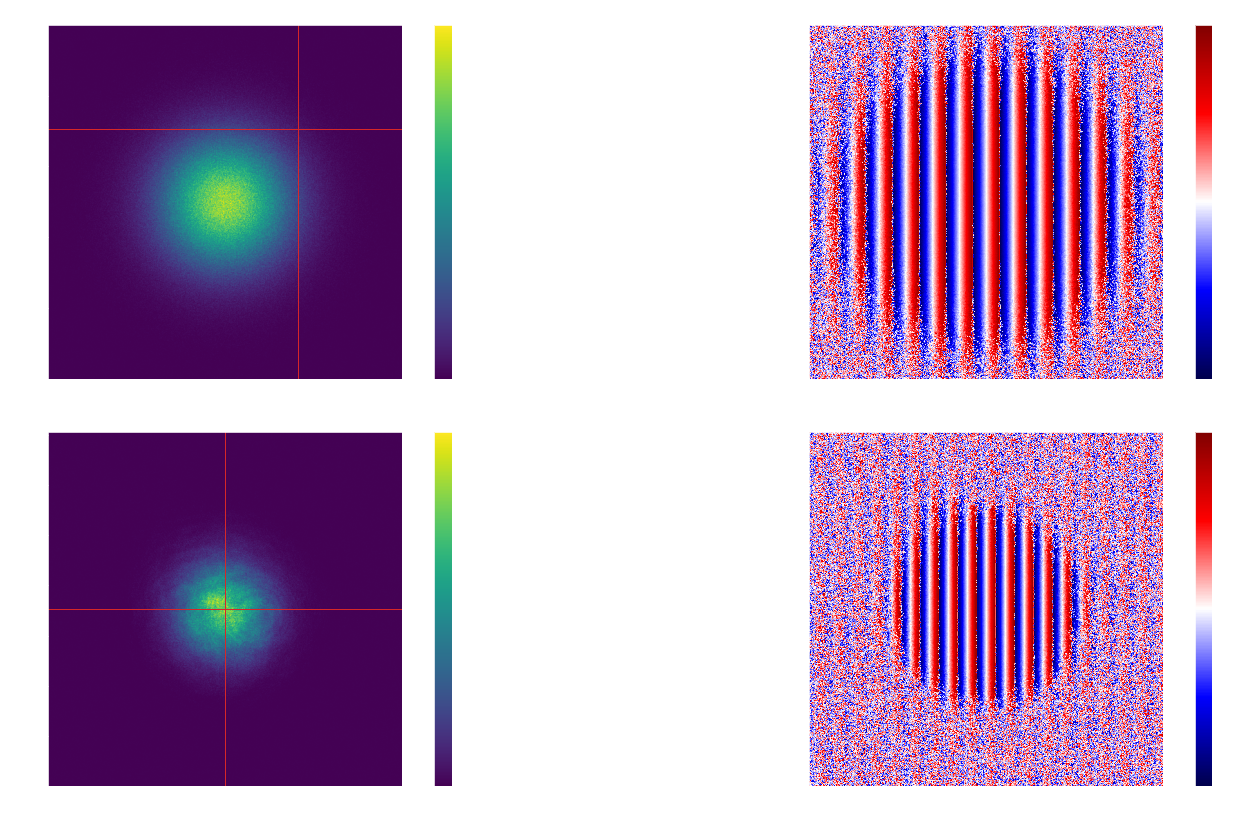

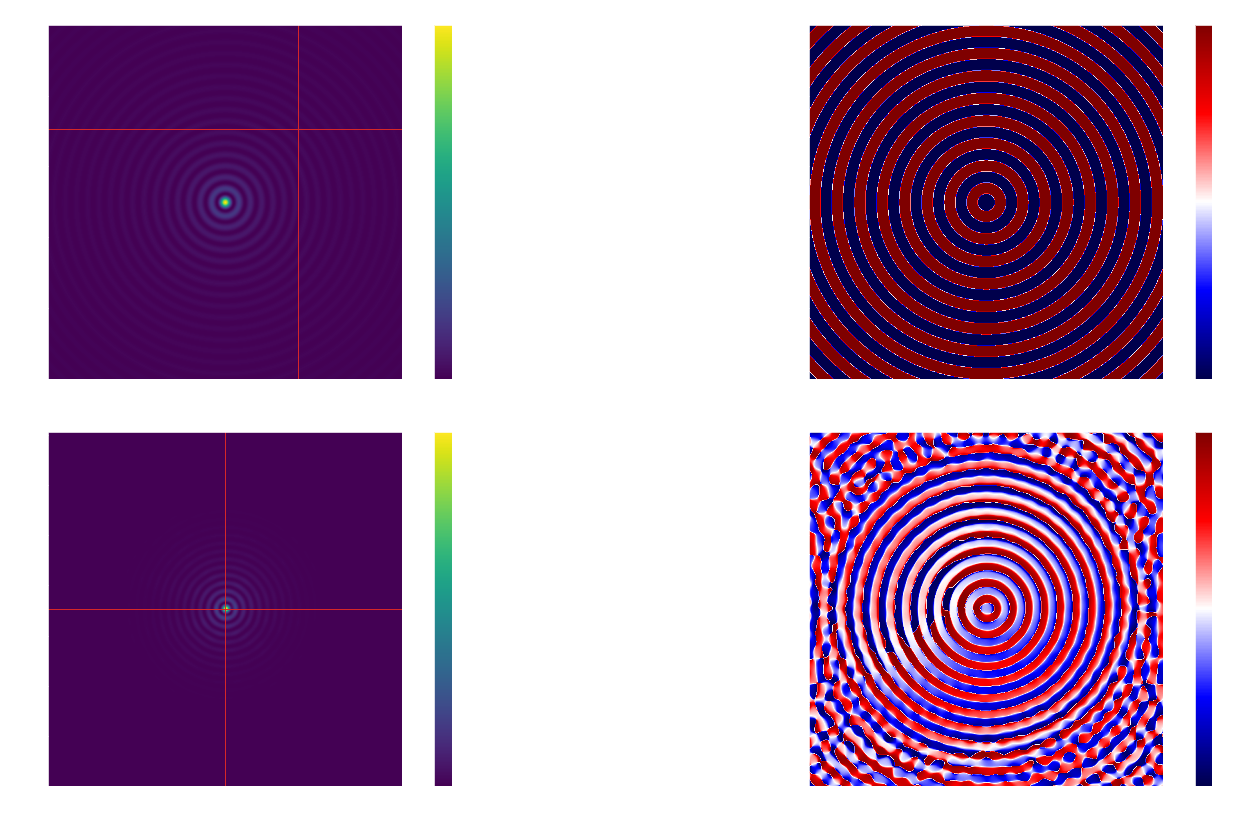

In [78]:
extent_general_an = [0, my_simulation_an.Nx*my_simulation_an.dx/factor_t/(1e-3), 0, my_simulation_an.Ny*my_simulation_an.dy/factor_t/(1e-3)]


fig = plt.figure(figsize=(25, 14))

rows = 2
columns = 2

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)

plt.subplot(grid[0, 0])
plt.title("Obstacle", fontsize=15)
plt.imshow(input_beam_profile_an, extent=extent_general_an)
plt.colorbar()
plt.axvline(x=x_center_4f*dx/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.axhline(y=y_center_4f*dy/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

plt.subplot(grid[0, 1])

plt.imshow(phase_input_beam_an, cmap="seismic", extent=extent_general_an)
plt.colorbar()
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

plt.subplot(grid[1, 0])
plt.title("Obstacle", fontsize=15)
plt.imshow(input_beam_profile, extent=extent_general)
plt.colorbar()
plt.axvline(x=x_center_4f*dx/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.axhline(y=y_center_4f*dy/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

plt.subplot(grid[1, 1])

plt.imshow(phase_input_beam, cmap="seismic", extent=extent_general)
plt.colorbar()
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")



fig = plt.figure(figsize=(25, 14))

rows = 2
columns = 2

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)

plt.subplot(grid[0, 0])
plt.title("Obstacle", fontsize=15)
plt.imshow(input_axicon_size_an, extent=extent_general_an)
plt.colorbar()
plt.axvline(x=x_center_4f*dx/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.axhline(y=y_center_4f*dy/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

plt.subplot(grid[0, 1])

plt.imshow(phase_axicon_an, cmap="seismic", extent=extent_general_an)
plt.colorbar()
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

plt.subplot(grid[1, 0])
plt.title("Obstacle", fontsize=15)
plt.imshow(input_axicon_size, extent=extent_general)
plt.colorbar()
plt.axvline(x=x_center_4f*dx/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.axhline(y=y_center_4f*dy/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

plt.subplot(grid[1, 1])

plt.imshow(phase_axicon, cmap="seismic", extent=extent_general)
plt.colorbar()
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

Text(0.5, 0, 'y [mm]')

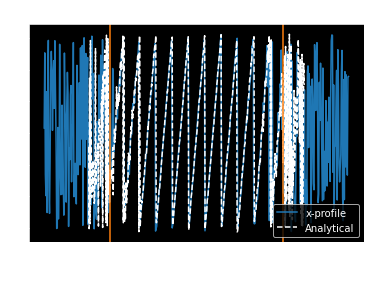

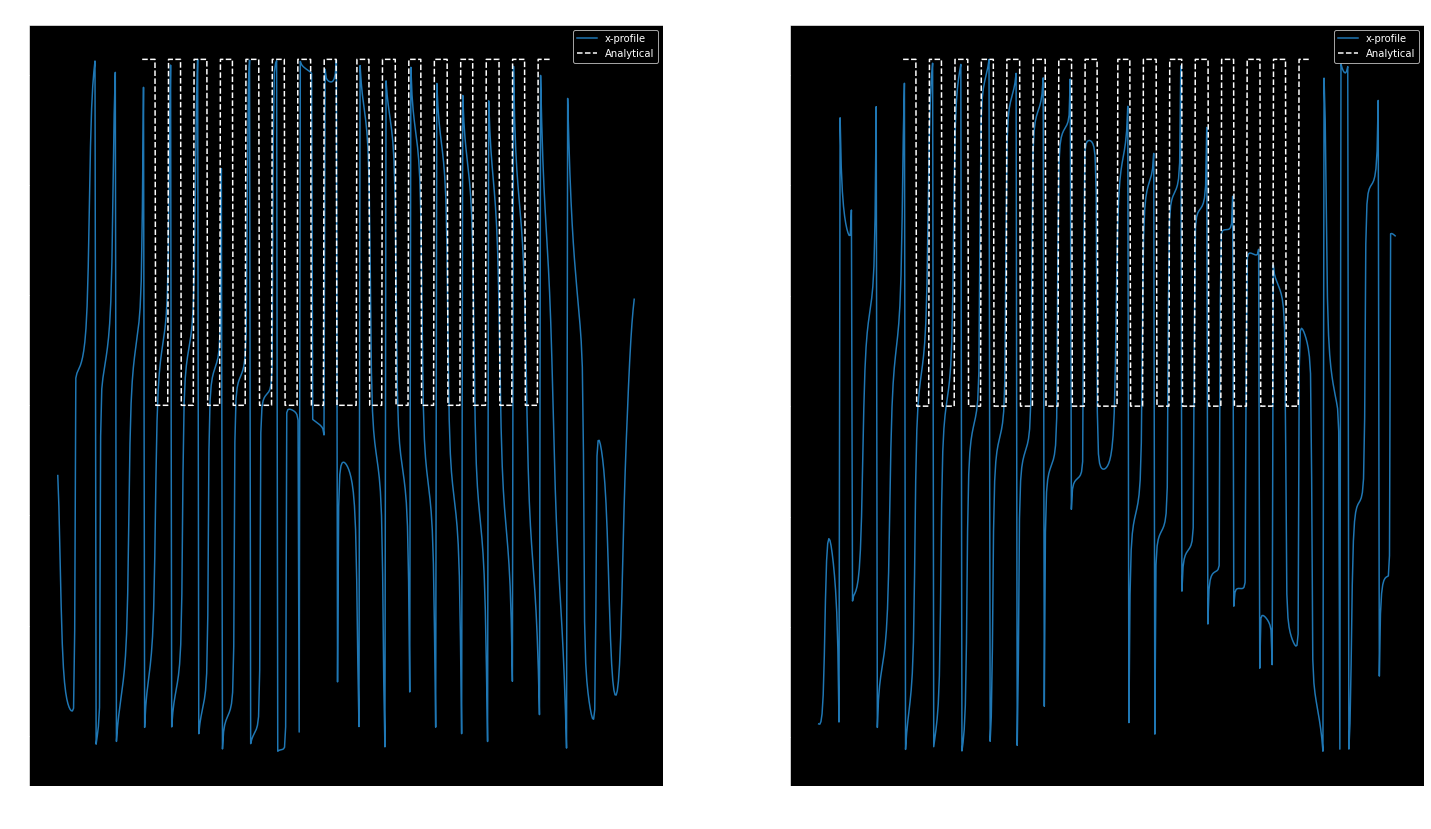

In [79]:
plt.figure()
plt.title("$x$ phase profile")
plt.plot(x_array/factor_t/(1e-3), phase_input_beam[256,:], label="x-profile", color="tab:blue")

plt.plot(x_array_an/factor_t/(1e-3), phase_input_beam_an[256,:], label='Analytical', color="white", linestyle="--")
plt.legend(loc=0)
plt.xlabel("x [mm]", fontsize=15)

plt.axvline(x=-1, color="tab:orange")
plt.axvline(x=1, color="tab:orange")

fig = plt.figure(figsize=(25, 14))

rows = 1
columns = 2

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)

plt.subplot(grid[0, 0])

plt.title("$x$ axicon phase profile")
plt.plot(x_array/factor_t/(1e-3), phase_axicon[256,:], label="x-profile", color="tab:blue")

plt.plot(x_array_an/factor_t/(1e-3), phase_axicon_an[256,:], label='Analytical', color="white", linestyle="--")
plt.legend(loc=0)
plt.xlabel("x [mm]", fontsize=15)

plt.subplot(grid[0, 1])

plt.title("$y$ axicon phase profile")
plt.plot(y_array/factor_t/(1e-3), phase_axicon[:,256], label="x-profile", color="tab:blue")

plt.plot(y_array_an/factor_t/(1e-3), phase_axicon_an[:, 256], label='Analytical', color="white", linestyle="--")
plt.legend(loc=0)
plt.xlabel("y [mm]", fontsize=15)

Using matplotlib backend: module://ipympl.backend_nbagg


(-0.25, 0.25)

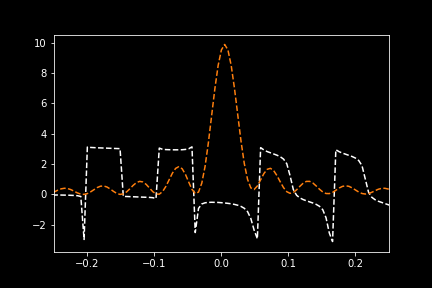

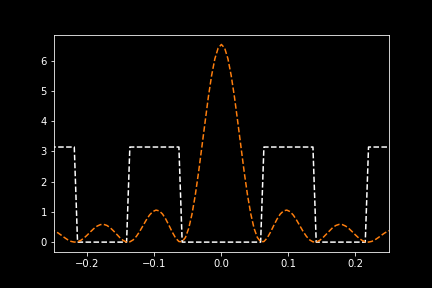

In [80]:
%matplotlib 

plt.figure()
plt.plot(x_array_an/factor_t/(1e-3), phase_axicon[256,:], label='Analytical', color="white", linestyle="--")
plt.plot(x_array_an/factor_t/(1e-3), profile_x_4f_input_axicon_size, label='Analytical', color="tab:orange", linestyle="--")
plt.xlim(xmin=-0.25, xmax=0.25)

plt.figure()
plt.plot(x_array_an/factor_t/(1e-3), phase_axicon_an[256,:], label='Analytical', color="white", linestyle="--")
plt.plot(x_array_an/factor_t/(1e-3), profile_x_4f_input_axicon_size_an, label='Analytical', color="tab:orange", linestyle="--")
plt.xlim(xmin=-0.25, xmax=0.25)